# Training a convolution neural network to classifiy retina image into left or right handed

Trains a simple convnet on the [DRIVE dataset](http://www.isi.uu.nl/Research/Databases/DRIVE/) [Staal et al, 2004].

J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "[Ridge based vessel segmentation in color images of the retina](http://www.isi.uu.nl/Research/Databases/DRIVE/id=855.html)", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.

In [4]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas as pd # load csv
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
from skimage.transform import resize # resize images

# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [5]:
# unzip data set
with zipfile.ZipFile("../data/DRIVE_retinal_image_data.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [6]:
# load training images
fns = sorted(glob.glob('../data/DRIVE/training/images/*.tif'))
#print(fns)
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('../data/DRIVE/test/images/*.tif'))
#print(fns)
x_test = np.array([tifffile.imread(fn) for fn in fns])
print(x_train.shape)
print(x_test.shape)

/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(31, 584, 565, 3)
(9, 584, 565, 3)


In [7]:
# load annotations (the order corresponds to the order of the images)
y_train = pd.read_csv('../data/DRIVE/training/annotation.csv', sep='\t')
y_test = pd.read_csv('../data/DRIVE/test/annotation.csv', sep='\t')
#print(y_train)
#print(y_test)
y_train = y_train.values[:,1]
y_test = y_test.values[:,1]
#print(y_test)
num_classes = 2

y_train.shape

(31,)

Plot some samples from the image data set with titles showing the ground truth labels

In [8]:
def plot_images(images, labels, gt=None):
    # reduce empty dimensions, if any
    images = np.squeeze(images)
    labels = np.squeeze(labels)
    numrows=int(np.ceil(np.sqrt(images.shape[0])))
    print(numrows)
    fig, axes = plt.subplots(nrows=numrows, ncols=numrows, figsize=(8,8), sharex=True, sharey=True)
    fig.tight_layout()
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=plt.get_cmap('gray_r'))
        ax.set_title('{}'.format(labels[i]), fontsize=18)
        ax.axis('off')
        
        # highlight wrong predictions is gt (ground truth) is provided
        if gt is not None:
            if gt[i] != labels[i]:
                ax.imshow(images[i], cmap=plt.get_cmap('viridis'))
                ax.set_title('{}≠{}'.format(labels[i], gt[i]), fontsize=18, fontdict={'color':'red'})


__Preprocessing__

We reduce the image size to 128x128 and convert from `uint8` to `float32` encoding and scale the values in our image to lie between 0 and 1.

In [9]:
img_height = 48
img_width = 48

In [10]:
def preprocess(ims):
    # convert to float32
    ims = ims.astype(np.float32)

    # scale to 0-1 interval
    if ims.max() > 1.0:
        ims /= 255.
    
    # resize to 128x128 
    ims = np.array([resize(im, (img_height,img_width,3), order=3) for im in ims])
    
    print('min: {}, max: {}, shape: {}, type: {}'.format(ims.min(), ims.max(), ims.shape, ims.dtype))
    return ims

x_train = preprocess(x_train)
x_test = preprocess(x_test)


/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


min: 0.0, max: 1.0, shape: (31, 48, 48, 3), type: float64
min: 0.0, max: 1.0, shape: (9, 48, 48, 3), type: float64


4


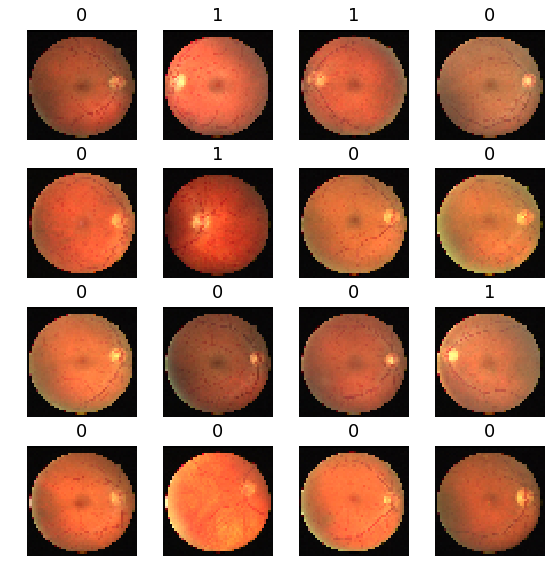

In [11]:
plot_images(x_train[:16], y_train[:16])

__One-hot encoding__

We need to convert the labels using the one-hot encoding scheme

In [12]:
# convert class vectors to binary class matrices
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Using TensorFlow backend.


# Define a convolutional neural network

In [13]:
def get_cnn():
    
    from keras.models import Model
    from keras import layers
    
    i = layers.Input(shape=(img_height,img_width,3))
    x = layers.BatchNormalization()(i)
    
    ## Convolutional part
    
    # conv layer with 32 3x3 filters and retified linear activation units
    # Note: first layer requires the specification of an input shape
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    # conv layer with 64 3x3 filters and retified linear activation units
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # conv layer with 128 3x3 filters and retified linear activation units
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # conv layer with 256 3x3 filters and retified linear activation units
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    ## Multilayer perceptron (MLP) part

    # first, we need to flatten the output of the conv to obtain a vector
    #x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling2D()(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.5)(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.5)(x)
    # final layer is equal to the number of classes and uses SoftMax activation 
    o = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=[i], outputs=[o])


__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

In [14]:
model = get_cnn()
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
__________

# Train the neural network

In [15]:
batch_size = 12
epochs = 200

In [16]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(31, 48, 48, 3)
(31, 2)
(9, 48, 48, 3)
(9, 2)


In [56]:
history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=2,
                      validation_data=(x_test, y_test))


Train on 31 samples, validate on 9 samples
Epoch 1/200
 - 0s - loss: 8.3480e-04 - acc: 1.0000 - val_loss: 0.3271 - val_acc: 0.8889
Epoch 2/200
 - 0s - loss: 0.0109 - acc: 1.0000 - val_loss: 0.2263 - val_acc: 0.8889
Epoch 3/200
 - 0s - loss: 6.8208e-04 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.8889
Epoch 4/200
 - 0s - loss: 2.2002e-04 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 1.0000
Epoch 5/200
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 1.0000
Epoch 6/200
 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.1325 - val_acc: 0.8889
Epoch 7/200
 - 0s - loss: 9.6240e-04 - acc: 1.0000 - val_loss: 0.3054 - val_acc: 0.8889
Epoch 8/200
 - 0s - loss: 1.3389e-04 - acc: 1.0000 - val_loss: 0.4074 - val_acc: 0.8889
Epoch 9/200
 - 0s - loss: 5.3684e-04 - acc: 1.0000 - val_loss: 0.4673 - val_acc: 0.8889
Epoch 10/200
 - 0s - loss: 1.7497e-04 - acc: 1.0000 - val_loss: 0.5072 - val_acc: 0.8889
Epoch 11/200
 - 0s - loss: 2.5920e-05 - acc: 1.0000 - val_loss: 0.5322 - val_acc: 0.8889

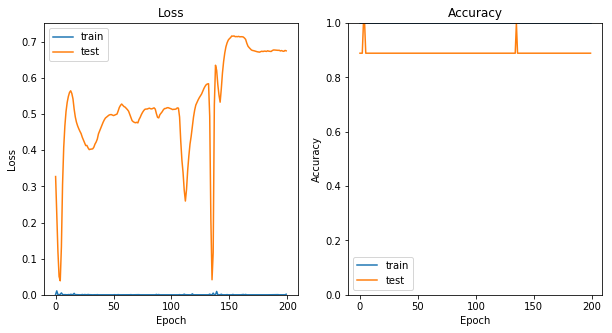

In [57]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['acc'])
    if validation:
        ax[1].plot(history.history['val_acc'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

In [58]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 0s 576us/step
Test loss: 0.674850642681
Test accuracy: 0.888888895512


# Predict unseen examples

In [59]:
num=36
import time
start = time.time()
y_pred = model.predict(x_test[:num], verbose=1, batch_size=12)
end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))

9/9 [==============================] - 0s 454us/step
Exec time per prediction = 0.000


Predictions are returned as vectors in one-hot encoding. Or rather, they are the activations of the last layer in the NN.

In [60]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 1])

In [61]:
gt = np.argmax(y_test[:num], axis=1) 
gt

array([1, 0, 1, 0, 1, 0, 0, 0, 1])

3


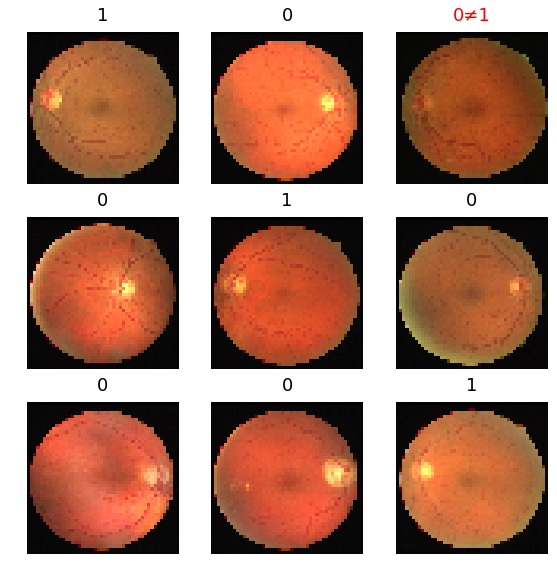

In [62]:
plot_images(x_test[:num], y_pred, gt=gt)

In [63]:
x_test.shape

(9, 48, 48, 3)

In [64]:
for i, l in enumerate(model.layers):
    print(i, l.name)

0 input_1
1 batch_normalization_1
2 conv2d_1
3 conv2d_2
4 max_pooling2d_1
5 conv2d_3
6 max_pooling2d_2
7 conv2d_4
8 max_pooling2d_3
9 global_average_pooling2d_1
10 dense_1
11 dropout_1
12 dense_2
13 dropout_2
14 dense_3


# Visualize class activation map

Based on [`keras-vis`](https://raghakot.github.io/keras-vis/)

In [65]:

from vis.visualization import visualize_cam, overlay
from vis.utils import utils
from keras import activations
from matplotlib import cm



class_idx =  1
class_idx =  1
class_idx =  0
class_idx =  0
class_idx =  1
class_idx =  0
class_idx =  1
class_idx =  1
class_idx =  1
class_idx =  1


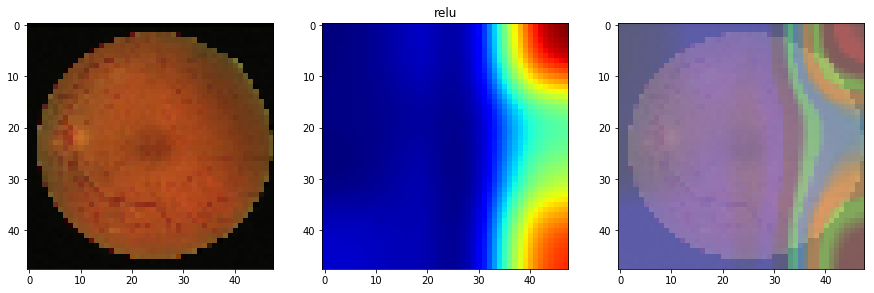

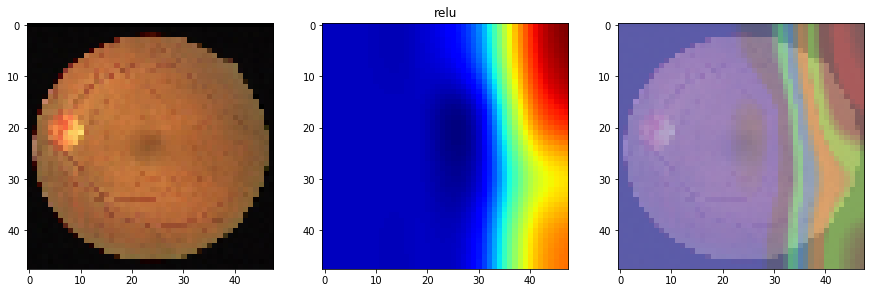

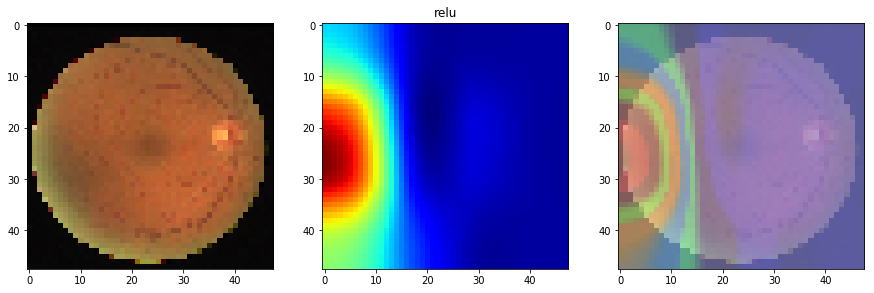

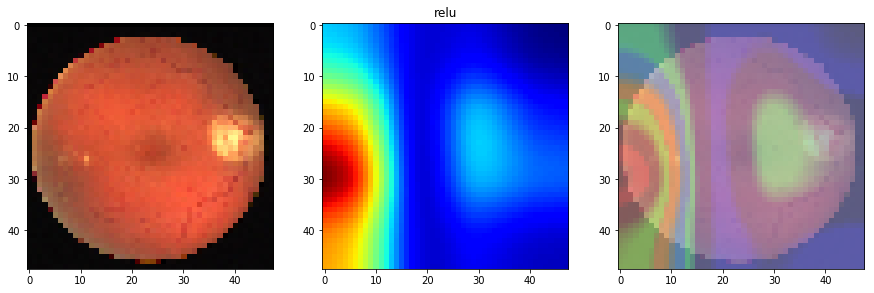

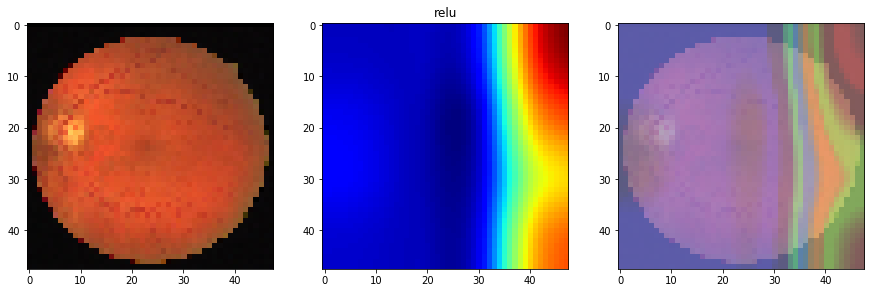

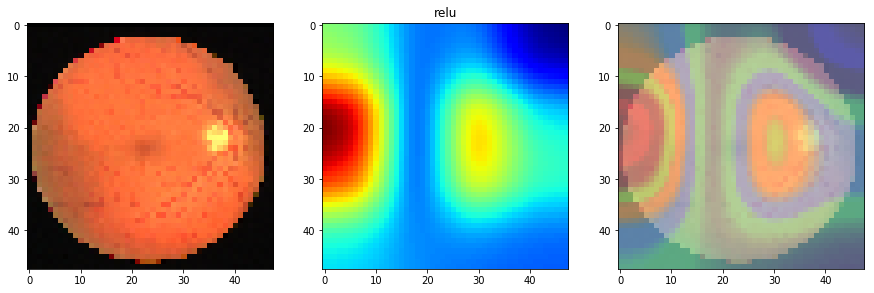

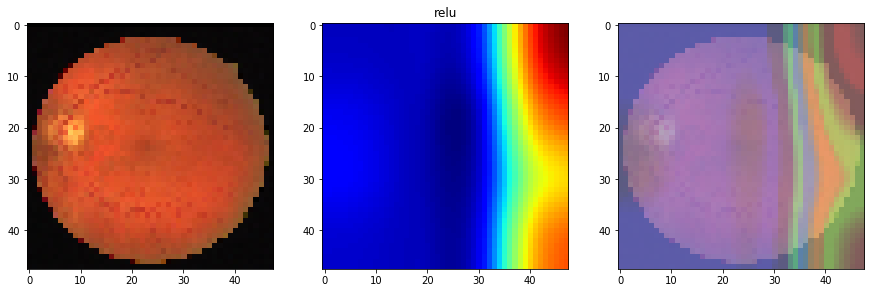

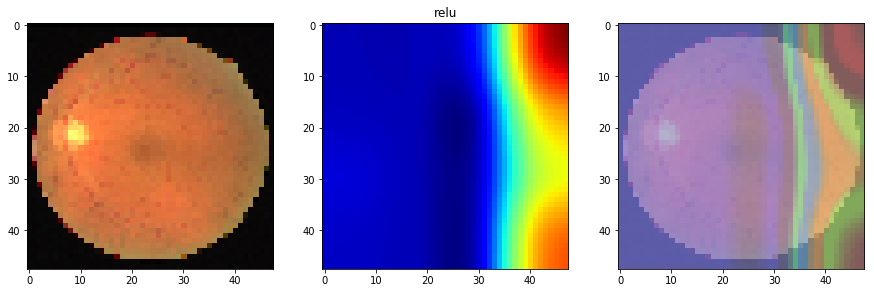

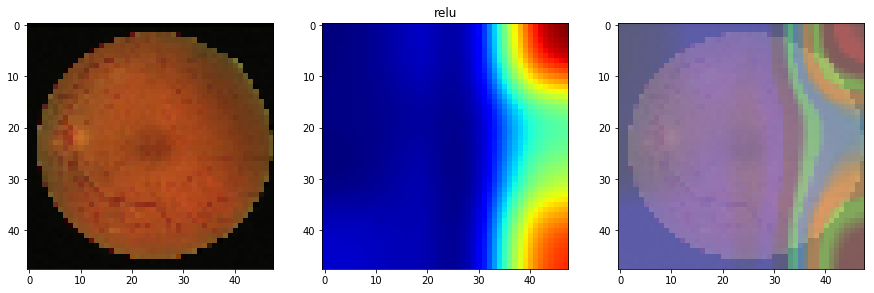

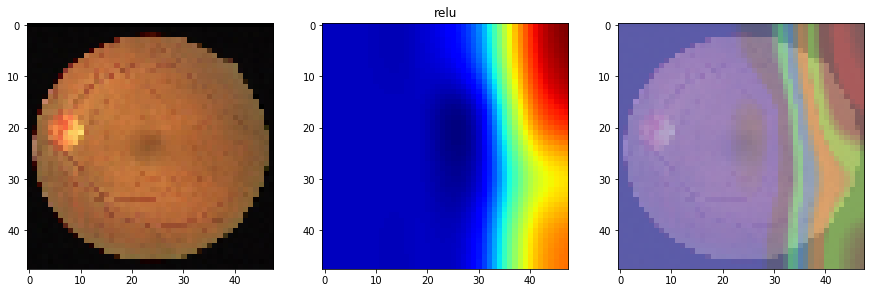

In [66]:
model_vis = utils.apply_modifications(model)

# This corresponds to the Dense linear layer.
n = 10
for i in np.arange(n):
    sample = np.random.choice(range(len(x_test)))
    image = x_test[sample]
    class_idx = np.argmax(y_test[sample], axis=-1)
    
    print("class_idx = ", class_idx)
    
    f, ax = plt.subplots(1, 3, figsize=(15,5*n))
    ax[0].imshow(image)
    
    for i, modifier in enumerate(['relu']): #[None, 'guided', 'relu']
        grads = visualize_cam(model, layer_idx=-1, penultimate_layer_idx=8, filter_indices=class_idx, 
                              seed_input=image, backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'none'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')
        jet_heatmap = np.uint8(cm.jet(grads)[...,0]*255)
        #print(jet_heatmap.shape)
        #print(image.shape)
        ax[2].imshow(overlay(jet_heatmap[:,:,:], ((image+1.0)/2.0)*255, alpha=0.3))
